In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 8]

In [161]:
def QuantAngles(ang,mag):
    cang = np.zeros((ang.shape[0],ang.shape[1],3))
    for i in range(3):
        cang[:,:,i] = ang
    for i in range(ang.shape[0]):
        for j in range(ang.shape[1]):
            if(mag[i,j]>0):
                # Horizontal gradient
                if  (-np.pi <= ang[i,j] < -7*np.pi/8) or (-np.pi/8 <= ang[i,j] < np.pi/8) or (7*np.pi/8 <= ang[i,j] <= np.pi):
                    cang[i,j] = np.array([1,0,0])
                # Main diagonal gradient
                elif  (-7*np.pi/8 <= ang[i,j] < -5*np.pi/8) or (np.pi/8 <= ang[i,j] < 3*np.pi/8):
                    cang[i,j] = np.array([0,1,0])
                # Vertical gradient
                elif  (-5*np.pi/8 <= ang[i,j] < -3*np.pi/8) or (3*np.pi/8 <= ang[i,j] < 5*np.pi/8):
                    cang[i,j] = np.array([0,0,1])
                # Secondary diagonal gradient
                elif  (-3*np.pi/8 <= ang[i,j] < -np.pi/8) or (5*np.pi/8 <= ang[i,j] < 7*np.pi/8):
                    cang[i,j] = np.array([1,1,0])
            else:
                cang[i,j] = np.array([0,0,0])
    return cang

def NonMax(mag,quant_ang):
    h,w = mag.shape
    res = np.zeros(mag.shape)
    for i in range(h):
        for j in range(w):
            if mag[i,j] > 0:
                # Horizontal gradient
                if np.array_equal(quant_ang[i,j],np.array([1,0,0])):
                    if mag[i,j] > mag[i,j-1] and mag[i,j] > mag[i,j+1]:
                        res[i,j] = mag[i,j]
                # Main diagonal gradient
                elif np.array_equal(quant_ang[i,j],np.array([0,1,0])):
                    if mag[i,j] > mag[i-1,j-1] and mag[i,j] > mag[i+1,j+1]:
                        res[i,j] = mag[i,j]
                # Vertical gradient
                elif np.array_equal(quant_ang[i,j],np.array([0,0,1])):
                    if mag[i,j] > mag[i-1,j] and mag[i,j] > mag[i+1,j]:
                        res[i,j] = mag[i,j]
                # Secondary diagonal gradient
                elif np.array_equal(quant_ang[i,j],np.array([1,1,0])):
                    if mag[i,j] > mag[i+1,j-1] and mag[i,j] > mag[i-1,j+1]:
                        res[i,j] = mag[i,j]
    return res

def Hysteresis(edges,t1,t2):
    hyst = np.zeros(edges.shape)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i,j] > t1:
                hyst[i,j] = 1
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i,j] > t2 and 1 in hyst[i-1:i+1,j-1:j+1]:
                hyst[i,j] = 0.5
    hyst[np.nonzero(hyst)] = 1
    return hyst

def Canny(img):
    res = img.copy()
    # 1. Gaussian Blur
    ker_size = 5
    blurred = cv2.GaussianBlur(res,(ker_size,ker_size),sigmaX=0,sigmaY=0)
    # 2. Partial Derivatives
    ker = np.array([-1,0,1])
    derY = cv2.filter2D(blurred,cv2.CV_64F,ker)
    derX = cv2.filter2D(blurred,cv2.CV_64F,np.reshape(ker,(1,3)))
    # 3. Magnitude and Direction of Gradient
    mag = np.sqrt(derX**2+derY**2)
    mag = mag/mag.max()
    ang = np.arctan2(derY,derX)
    # 4. Quantize the gradient directions
    cang = QuantAngles(ang,mag)
    # 5. Non-max suppression
    nonmax = NonMax(mag,cang)
    # 6. Hysteresis
    t1 = 0.3*nonmax.max()
    t2 = 0.05*nonmax.max()
    hyst = Hysteresis(nonmax,t1,t2)
                
    return res,derX,derY,mag,ang,cang,nonmax,hyst

In [162]:
img = cv2.imread('images/circle.png',0)
res = Canny(img)

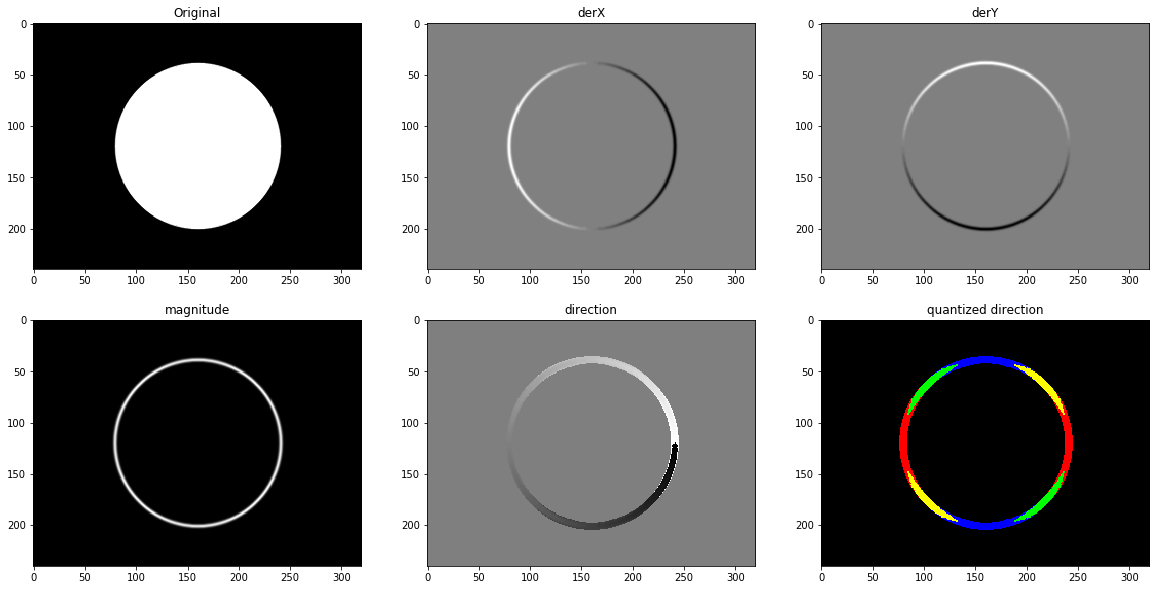

In [163]:
fig = plt.figure(figsize=(20, 10))
a = fig.add_subplot(2,3,1)
plt.imshow(img,'gray')
a.set_title('Original')
a = fig.add_subplot(2,3,2)
plt.imshow(res[1],'gray')
a.set_title('derX')
a = fig.add_subplot(2,3,3)
plt.imshow(res[2],'gray')
a.set_title('derY')
a = fig.add_subplot(2,3,4)
plt.imshow(res[3],'gray')
a.set_title('magnitude')
a = fig.add_subplot(2,3,5)
plt.imshow(res[4],'gray')
a.set_title('direction')
a = fig.add_subplot(2,3,6)
plt.imshow(res[5])
a.set_title('quantized direction')
plt.show()

In [164]:
img = cv2.imread('images/chess.jpg',0)
res = Canny(img)

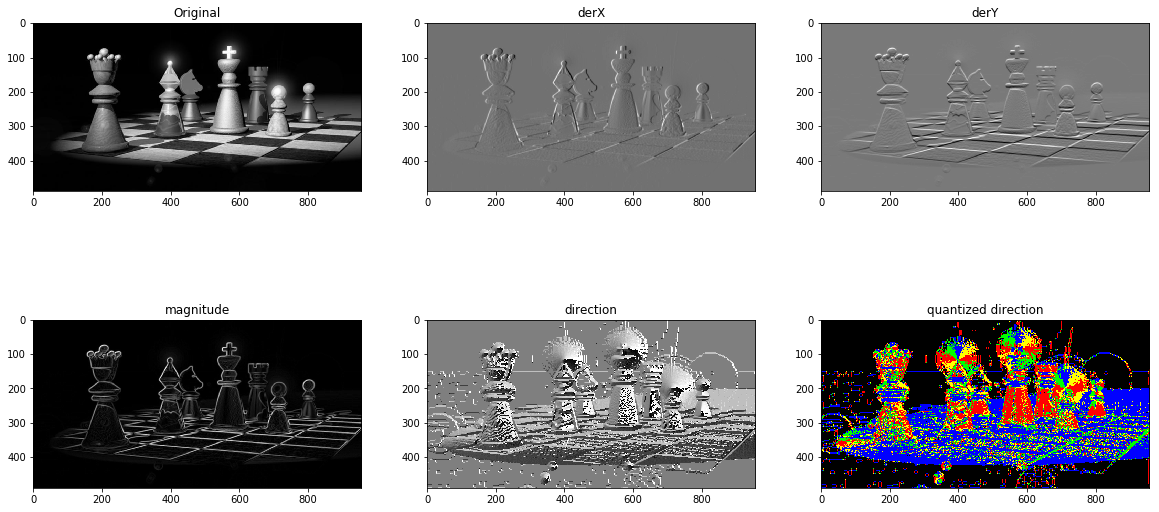

In [165]:
fig = plt.figure(figsize=(20, 10))
a = fig.add_subplot(2,3,1)
plt.imshow(img,'gray')
a.set_title('Original')
a = fig.add_subplot(2,3,2)
plt.imshow(res[1],'gray')
a.set_title('derX')
a = fig.add_subplot(2,3,3)
plt.imshow(res[2],'gray')
a.set_title('derY')
a = fig.add_subplot(2,3,4)
plt.imshow(res[3],'gray')
a.set_title('magnitude')
a = fig.add_subplot(2,3,5)
plt.imshow(res[4],'gray')
a.set_title('direction')
a = fig.add_subplot(2,3,6)
plt.imshow(res[5])
a.set_title('quantized direction')
plt.show()

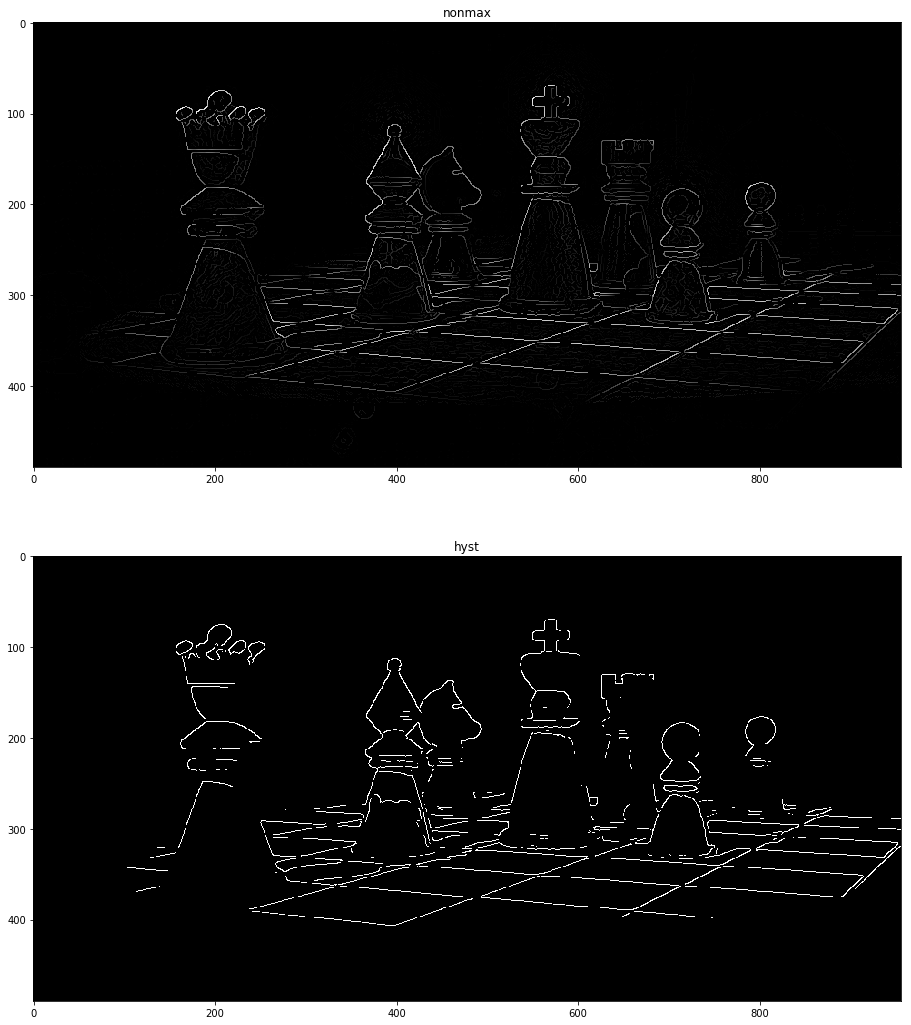

In [166]:
fig = plt.figure(figsize=(20, 18))
a = fig.add_subplot(2,1,1)
plt.imshow(res[6],'gray')
a.set_title('nonmax')
a = fig.add_subplot(2,1,2)
plt.imshow(res[7],'gray')
a.set_title('hyst')
plt.show()